<h1 align='center'>EE5907_CA2  &nbsp; &nbsp;&nbsp;&nbsp;     Yang Di &nbsp; &nbsp;&nbsp;&nbsp;    A0229522H<h1>
<h2>Part 4: Neural Networks for Classification<h2>

In this part, I will train a CNN with two convolutional layers and one fully connected layer, with the architecture specified as follows: number of nodes: 20-50-500-26. The number of the nodes in the last layer is fixed as 26 as we are per- forming 26-category (25 CMU PIE faces plus 1 for myself) classification. Convolutional kernel sizes are 5. Each convolutional layer is followed by a max pooling layer with a kernel size of 2 and stride of 2. 

In [1]:
import numpy as np
import math
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt



In [2]:
import random
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

import  tensorflow.compat.v1  as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
#import tensorflow.keras.layers.advanced_activations
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.layers import Dropout, Flatten, MaxPooling2D
# FOR old tensorflow version： tensorlow.keras above can be replaced with keras only


In [3]:
path = os.path.abspath('MINE')  # to get the path of my own photo without process.

import random

def random_select(num, start, end, seed): # to randomly select 25 picture sets from PIE and randomly select pictures as training set
    random.seed(seed)
    selected_id = [i for i in range(start,end)]
    random.shuffle(selected_id)
    return sorted(selected_id[0:num])

# choose 25 PIE subjects 
selected_id = random_select(num=25, start=1, end=68,seed=90) 
print("Selected subset's id is shown:", selected_id)

Selected subset's id is shown: [1, 6, 11, 13, 14, 15, 16, 19, 21, 22, 26, 28, 31, 33, 36, 39, 42, 45, 46, 55, 56, 58, 59, 60, 61]


The number of chosen images: 4250
Image size: (32, 32)
Training set: 2975 (0.7) Test set: 1275 (0.3)

 randomly display ten photos from dataset


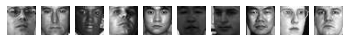

In [4]:
#to load data from chosen CMU dataset.
train_img = []
train_label = []
test_img = []
test_label = []

for file in selected_id:
    # Please replace the address of PIE here with you PIE folder's complete address
    wd = os.path.join("PIE/",str(file))     # load work address of each subset
    chosen_img = []           
    corre_label = []
    
    for img_id in os.listdir(wd):
        path = os.path.join(wd, img_id)
        img = plt.imread(path)
        chosen_img.append(img)
        corre_label.append(int(file))

# For each chosen subject,70% of the contained images are for training and the remaining 30% is for testing.    
    train_idx = random_select(num=round(len(chosen_img)*0.7),start=0, end=len(chosen_img), seed=20)
    #print(train_idx)
    
    for i in range(0,len(chosen_img)):
            if i in train_idx:
                train_img.append(chosen_img[i])
                train_label.append(corre_label[i])
            else:
                test_img.append(chosen_img[i])            
                test_label.append(corre_label[i])
            
        # right here, i choose to use probably approach to separate images, 
        #the training number and test number can be exactly equal to 2975(0.7) and 1275(0.3).

print("The number of chosen images:",len(train_label)+len(test_label))        
print("Image size: {}\nTraining set: {} ({}) Test set: {} ({})".format(train_img[0].shape, len(train_label),
                                                                     len(train_label)/(len(train_label)+len(test_label)), 
                                                                     len(test_label),len(test_label)/(len(train_label)+len(test_label))))
fig, axs= plt.subplots(1, 10) 

for i in range(10):          
    img = random.choice(train_img)         
    axs[i].imshow(img, cmap='gray')              
    axs[i].axis('off') 

print('\n randomly display ten photos from dataset')  
plt.show()

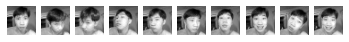

In [5]:
#To load my selftaken photo set
my_img= []
my_label = []
for i in os.listdir("MINE/OP/"):
    img = plt.imread("MINE/OP/"+i)
    my_img.append(img)
    my_label.append('myphoto')

    # right here i just mannually seperate my photos into 2 part, due to the number of photos is small.  
my_train_img = my_img[0:7]
my_test_img = my_img[7:10]
my_train_label = my_label[0:7]
my_test_label = my_label[7:10]

fig, axs = plt.subplots(1, 10)

for i in range(10):
    img = my_img[i]
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off') 
    
plt.show()

In [6]:
train_img.extend(my_train_img)
train_label.extend(my_train_label)
test_img.extend(my_test_img)
test_label.extend(my_test_label)
print("Training set: {}  Testing set: {}".format(len(train_label), len(test_label)))

train_x = np.array(train_img)
train_y = np.array(train_label)
test_x = np.array(test_img)
test_y = np.array(test_label)
train_x = train_x.reshape(len(train_img), -1)
test_x = test_x.reshape(len(test_img), -1)
print("Training set {}    Testing set{}".format(train_x.shape, test_x.shape))


Training set: 2982  Testing set: 1278
Training set (2982, 1024)    Testing set(1278, 1024)


In [7]:
Input_shape = (32,32,1) # images input size.
Batch_size = 64 # the number of data samples used in one training session;
Epochs = 30 # 30 training session

#the specialization of the CNN Model
CNN = Sequential()
CNN.add(Conv2D(20, kernel_size=(5,5), activation='relu',padding='same',
               kernel_regularizer='l2',input_shape=Input_shape))
CNN.add(MaxPooling2D(pool_size=(2,2), strides=2))
CNN.add(Conv2D(50, kernel_size=(5,5), activation='relu',padding='same',
               kernel_regularizer='l2'))
CNN.add(MaxPooling2D(pool_size=(2,2), strides=2))
CNN.add(Conv2D(500, kernel_size=(5,5), activation='relu',padding='same',
               kernel_regularizer='l2'))
CNN.add(MaxPooling2D(pool_size=(2,2), strides=2))
CNN.add(Flatten())
CNN.add(Dense(26,kernel_regularizer='l2',activation='softmax'))

CNN.compile(loss='categorical_crossentropy', optimizer = 'adam',metrics=['accuracy'])
print(CNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 50)        25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 500)         625500    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 500)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0

In [8]:
#transform data into image form(32 by 32)
train_data = train_x.reshape(train_x.shape[0], 32, 32 ,1)
test_data = test_x.reshape(test_x.shape[0], 32, 32 ,1)

#ransform label in to onehot encoded form form(n by 1)
a,b,c,train= np.unique(train_y,return_counts=True,return_index=True,return_inverse=True)
new_train_label = []
for i in range(len(train)):
    label = [i]*train[i]
    new_train_label = new_train_label + label
    
a,b,c,test= np.unique(test_y,return_counts=True, return_index=True,return_inverse=True)
new_test_label = []

for i in range(len(test)):
    label = [i]*test[i]
    new_test_label = new_test_label + label
    

new_train_label = to_categorical(new_train_label)
new_test_label = to_categorical(new_test_label)

In [9]:
# Start to training CNN
print('CNN Under Training, please wait')
print('\n')
History=CNN.fit(train_data, new_train_label,validation_data = (test_data,new_test_label),batch_size=Batch_size,epochs=Epochs,verbose=1)

CNN Under Training, please wait


Epoch 1/30
47/47 [==============================] - 6s 126ms/step - loss: 7.9333 - accuracy: 0.1284 - val_loss: 4.1490 - val_accuracy: 0.2817
Epoch 2/30
47/47 [==============================] - 6s 122ms/step - loss: 3.0822 - accuracy: 0.5620 - val_loss: 2.3680 - val_accuracy: 0.7606
Epoch 3/30
47/47 [==============================] - 6s 122ms/step - loss: 2.0816 - accuracy: 0.8488 - val_loss: 1.8597 - val_accuracy: 0.9100
Epoch 4/30
47/47 [==============================] - 6s 122ms/step - loss: 1.6985 - accuracy: 0.9282 - val_loss: 1.6650 - val_accuracy: 0.9257
Epoch 5/30
47/47 [==============================] - 6s 123ms/step - loss: 1.4910 - accuracy: 0.9584 - val_loss: 1.4808 - val_accuracy: 0.9499
Epoch 6/30
47/47 [==============================] - 6s 124ms/step - loss: 1.3620 - accuracy: 0.9678 - val_loss: 1.3588 - val_accuracy: 0.9570
Epoch 7/30
47/47 [==============================] - 6s 125ms/step - loss: 1.2226 - accuracy: 0.9846 - val_loss: 1.

In [10]:
print('\n')
print('under Testing, please wait')
print('\n')
score = CNN.evaluate(train_data, new_train_label, verbose=0)
print('Loss on train dataset: {}    Classification accuracy on train dataset: {}%:'.format(score[0],score[1]*100))
print('\n')
score1 = CNN.evaluate(test_data, new_test_label, verbose=0)
print('Loss on test dataset: {}    Classification accuracy on test dataset: {}%:'.format(score1[0],score1[1]*100))



under Testing, please wait


Loss on train dataset: 0.4919218122959137    Classification accuracy on train dataset: 98.52448105812073%:


Loss on test dataset: 0.5943239331245422    Classification accuracy on test dataset: 95.6181526184082%:


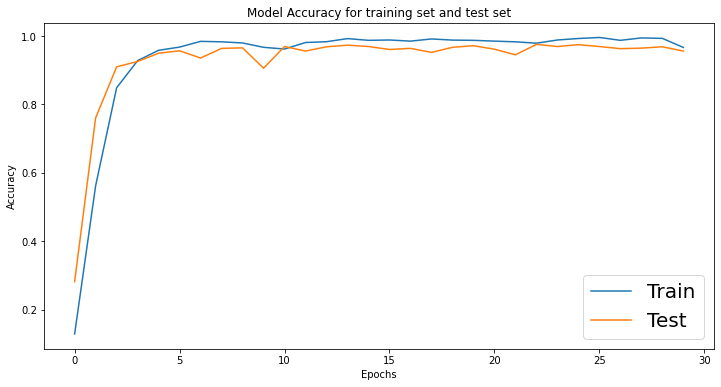

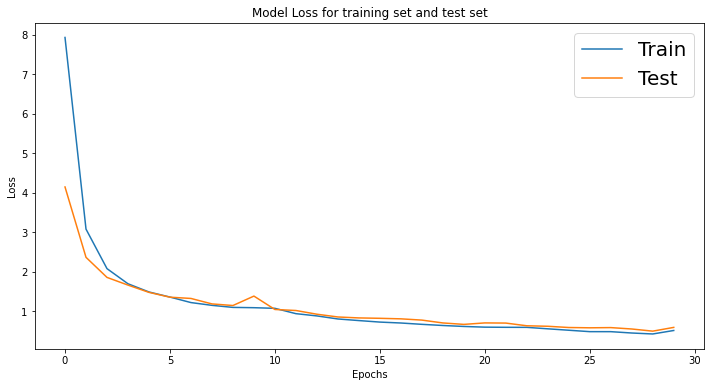

In [11]:
# summarize history for train accuracy and test accuracy

epochs = [i for i in range(30)]

plt.figure(figsize=(12, 6))
sns.lineplot(y = History.history['accuracy'], x = epochs)
sns.lineplot(y = History.history['val_accuracy'], x = epochs)
plt.title('Model Accuracy for training set and test set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'],fontsize = 20, loc='best')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(y = History.history['loss'], x = epochs)
sns.lineplot(y = History.history['val_loss'], x = epochs)
plt.title('Model Loss for training set and test set')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], fontsize = 20, loc='best')
plt.show()


As shown above, with a fixed Batch size, the accuray of model will come to a steady performance when training epoch is up to around 6.